## Setup


If you are running locally(i.e. in a jupyter notebook in conda, just make sure you installed:
- RDKit
- DeepChem 2.5.0 & above
- Tensorflow 2.4.0 & above

Then, please skip the following part and continue from `Data Preparations`.

To increase efficiency, we recommend running in Colab.

Then, we'll first need to run the following lines of code, these will download conda with the deepchem environment in colab.

In [1]:
#!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
#import conda_installer
#conda_installer.install()
#!/root/miniconda/bin/conda info -e

In [2]:
#!pip install --pre deepchem
#import deepchem
#deepchem.__version__

## Data Preparations

Now we are ready to import some useful functions/packages, along with our model.

### Import Data

In [1]:
import model##our model

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import deepchem as dc 

## Select subset for training

In [22]:
df = pd.read_csv('AID1706_binarized_sars.csv')

In [40]:
df_false = df[df['activity']==0].sample(n=2000, replace = False)#s
df_true = df[df['activity'] == 1]
df_subset = pd.concat([df_false, df_true], ignore_index = True)

In [117]:
def prepare_data(input_df, minimum_length ):
    '''
    this function:
    1. prepares the data(set minimum length)(exclusive)
    2. featurize
    
    
    '''
    try:
        from rdkit import Chem
    except ModuleNotFoundError:
        raise ImportError("This function requires RDKit to be installed. To install, refer to here: https://www.rdkit.org/docs/Install.html")
    
    #get the length and exclude those shorter than minimum length
    input_df['length'] = input_df['smiles'].apply(lambda x :Chem.MolFromSmiles(x).GetNumAtoms())
    df = input_df[input_df['length'] > minimum_length]
    
    y = df['activity']
   
    #featurize
    
    #out = featurizer.featurize(smiles)
    
    
    return featurize(df[smiles]), y
    

In [116]:
def featurize(column):
    '''
    
    '''
    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    feats = featurizer.featurize(column)
    
    train_nodes = [ i.node_features.sum(axis = 0) for i in feats ]
    train_edges = [ e.edge_features.sum(axis = 0) for e in feats ]
    
    return train_nodes, train_edges

In [106]:
n, r, y = prepare_data(df_subset, 12)

In [107]:
y

0       0
1       0
2       0
3       0
4       0
       ..
2400    1
2401    1
2402    1
2403    1
2404    1
Name: activity, Length: 2392, dtype: int64

Observe the data above, it contains a 'smiles' column, which stands for the smiles representation of the molecules. There is also an 'activity' column, in which it is the label specifying whether that molecule is considered as hit for the protein.

Here, we only need those 405 molecules considered as hits, and we'll be extracting features from them to generate new molecules that may as well be hits.

### Set Minimum Length for molecules

Since we'll be using graphic neural network, it might be more helpful and efficient if our graph data are of the same size, thus, we'll eliminate the molecules from the training set that are shorter(i.e. lacking enough atoms) than our desired minimum size.

In [19]:
num_atoms = 12 #here the minimum length of molecules is 12

In [75]:
input_df = input_df.apply( lambda x: model.featurizer(x,max_length = 11))

## Train test split

In [78]:
from sklearn.model_selection import train_test_split

We'll take one more step to make the train_set into separate nodes and edges, which fits the format later to supply to the model for training

In [80]:
nodes_train, edges_train = list(zip(*x_train) )
nodes_test, edges_test = list(zip(*x_test))

Now, we're finally ready for training. We'll first import some necessary functions from tensorflow.

## Model

In [92]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Here we'll first initiate a discriminator and a generator model with the corresponding functions in the package.

In [93]:
def make_model():
      # conv part for learning edges matrix features
    conv_edge = tf.keras.layers.Dense(32, activation = 'relu')
    edges_tensor = tf.keras.layers.Input(shape = (11,), name = 'edges')
    x_edge = conv_edge(edges_tensor)
  
    x_edge = tf.keras.layers.Dense(32, activation='relu')(x_edge)
    #x_edge = tf.keras.layers.Flatten()(x_edge) 
    x_edge = tf.keras.layers.Dropout(0.2)(x_edge)
    x_edge = tf.keras.layers.Dense(64, activation = 'relu')(x_edge)

    # dense layer part for nodes array features
    nodes_tensor = tf.keras.layers.Input(shape = (30,), name = 'nodes' )
    x_node = tf.keras.layers.Dense(32, activation = 'relu' )(nodes_tensor)
    x_node = tf.keras.layers.Dropout(0.2)(x_node)
    x_node = tf.keras.layers.Dense(64, activation = 'relu')(nodes_tensor)

    main = tf.keras.layers.concatenate([x_node,x_edge], axis = 1)
    main = tf.keras.layers.Dense(32, activation='relu')(main)
    output = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'label')(main)#binary classfication task with sigmoid as the activation
    
    model = keras.Model(
       inputs = [nodes_tensor, edges_tensor],
       outputs = output
       )
    model.compile(loss='binary_crossentropy', optimizer='adam')
  
    return model


In [94]:
mo = make_model()

### Set weight & Training

In [86]:
hit_count, nonhit_count = np.bincount(ihbt['activity'])
total_count = len(ihbt['activity'])
weight_nonhit = (1 / nonhit_count) * (total_count) / 2.0
weight_hit = (1 / hit_count) * (total_count) / 2.0
class_weights = {0: weight_nonhit, 1: weight_hit}

In [108]:
mo.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = mo.fit([np.array(n), np.array(r)],
                    y,
                    epochs=80, 
                    verbose = False,
                    #class_weight=class_weights
                    #steps_per_epoch = 100,
                    )

[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'training accuracy')]

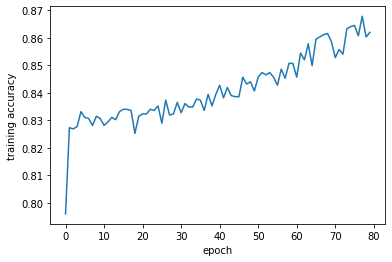

In [109]:
plt.plot(history.history["accuracy"])
plt.gca().set(xlabel = "epoch", ylabel = "training accuracy")

In [92]:
mo.predict([np.array(nodes_test), np.array(edges_test)]).argmax(axis=0)

array([272])

In [115]:
mo.predict([np.array(n), np.array(r)])


array([[0.4120218 ],
       [0.0631713 ],
       [0.05490926],
       ...,
       [0.27040404],
       [0.361502  ],
       [0.20556018]], dtype=float32)

In [114]:
df_subset.iloc[2055]

smiles      C1=CC=C2C(=C1)C(=CC(=C2N)C(C(F)(F)F)(C(F)(F)F)...
activity                                                    1
length                                                     31
Name: 2055, dtype: object

## Payoff

In [ ]:
def test(df, model):
    '''
    parameters:
    ---------
    
    df: molecules to be tested
    model: a trained model for prediction
    '''
    model.predict(df)

In [ ]:
df_false = df[df['activity']==0].sample(n=2000, replace = False)#s
df_true = df[df['activity'] == 1]
df_test_subset = pd.concat([df_false, df_true], ignore_index = True)

In [104]:
test_df = pd.DataFrame(x_test)
test_df = test_df.reset_index()

In [108]:
test_df.take([272])

,index,smiles
272,1615,"([6, 6, 6, 7, 6, 6, 17, 7, 6, 7, 6], [[0, 4, 0..."


In [109]:
df.take([1615])

,smiles,activity
1615,CN1C2=C(C=CC=N2)N=C1SCC(=O)N3CCC4=CC=CC=C43,0


## Drafts

In [118]:
smiles = ["C1CCC1", "C1=CC=CN=C1"]
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
out = featurizer.featurize(smiles)




In [72]:

t[0].node_features.sum(axis = 0)


array([19.,  1.,  5.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 23.,
        3.,  2.,  6., 12.,  0.,  4.,  2., 18.,  2.,  0.,  0., 14., 11.,
        0.,  1.,  0.,  0.])

In [86]:

len(t[1].node_features.sum(axis = 0))


30

In [88]:
len(t[0].edge_features.sum(axis = 0))


11